In [1]:
import sys
sys.path.insert(0, '..')

%load_ext tools.prov_magics
import tools.view.provn

3


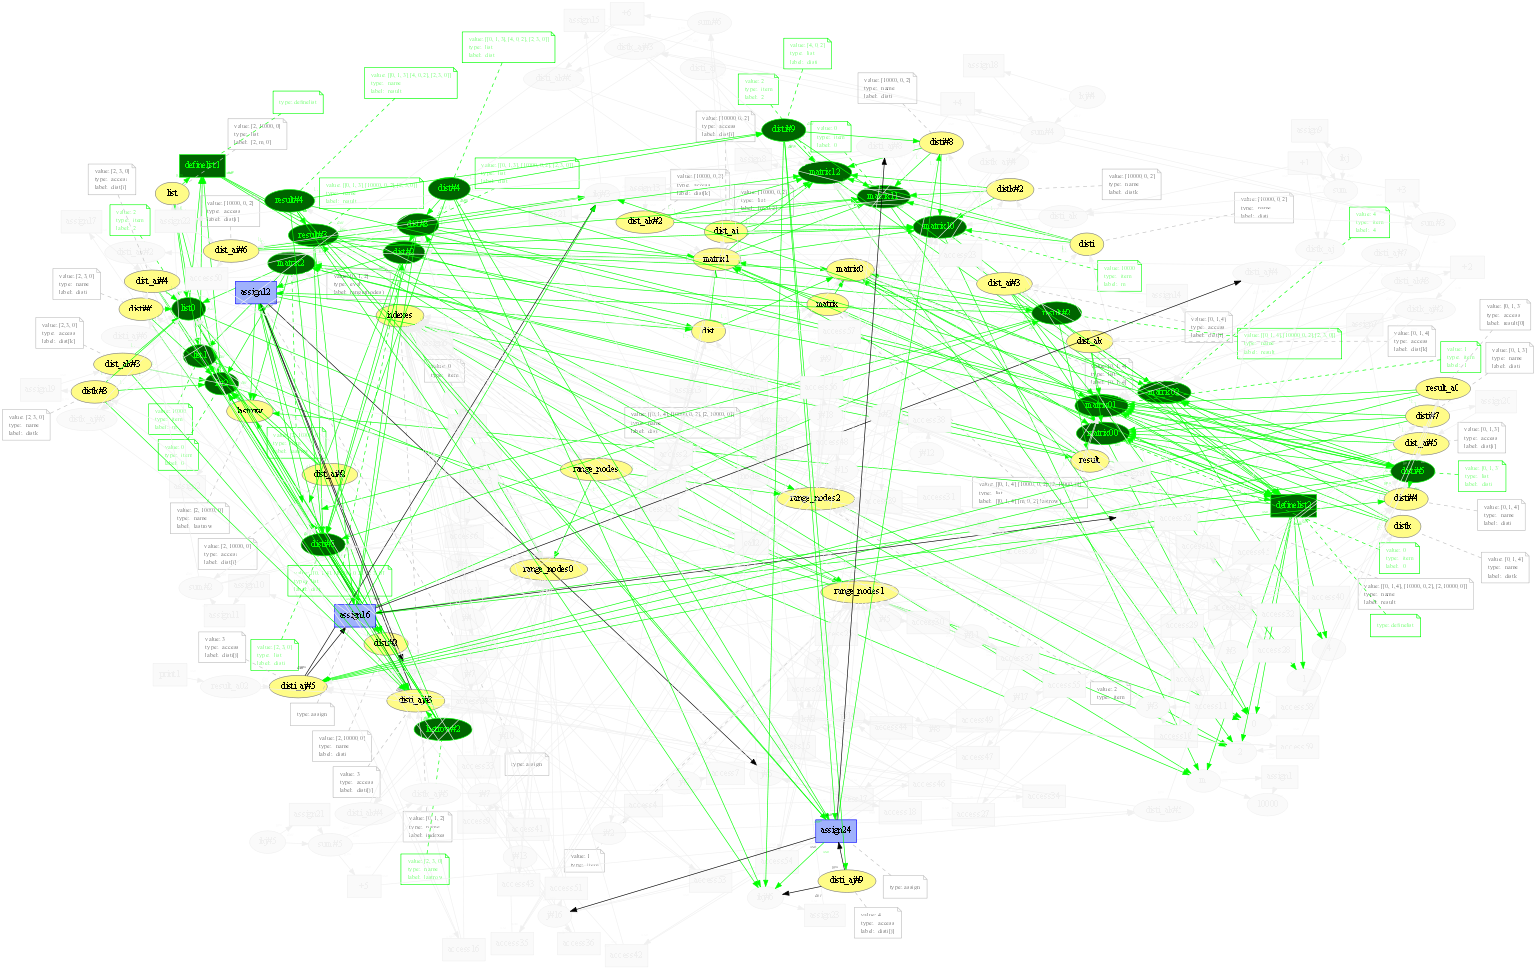

{'all': {2: [('entity', 2), ('activity', 1), ('wasDerivedFrom', 1)],
         3: [('entity', 7),
             ('hadMember', 6),
             ('wasDerivedFrom', 4),
             ('activity', 2),
             ('wasGeneratedBy', 1)],
         4: [('hadMember', 18),
             ('entity', 14),
             ('wasDerivedFrom', 9),
             ('wasGeneratedBy', 4),
             ('activity', 3)],
         10: [('entity', 2),
              ('activity', 2),
              ('used', 1),
              ('wasGeneratedBy', 1),
              ('wasDerivedFrom', 1)],
         11: [('hadMember', 6),
              ('entity', 5),
              ('wasGeneratedBy', 4),
              ('activity', 2),
              ('used', 1),
              ('wasDerivedFrom', 1)],
         12: [('entity', 3),
              ('activity', 3),
              ('wasDerivedFrom', 3),
              ('used', 3)],
         13: [('hadMember', 18),
              ('entity', 6),
              ('activity', 6),
              ('wasDerivedFrom'

In [2]:
import importlib
import tools.annotations as prov
importlib.reload(prov)
%run prov_floydwarshall.py